# A fractal of any shape

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from cutcutcodec.core.generation.video.fractal.fractal import mandelbrot

In [2]:
# create a shape
image = np.zeros((5000, 5000), dtype=np.uint8)
font_scale = image.shape[0] // 40
thickness = 4 * font_scale
org = (image.shape[0] // 4, 3 * image.shape[0] // 4)
image = cv2.putText(image, "M", org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (1, 1, 1), thickness)
# image = cv2.putText(image, "Fractal", org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness//2)  # for edges only

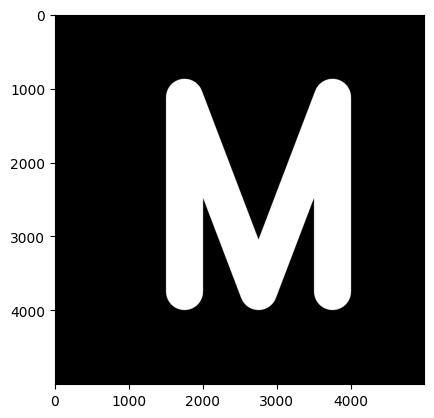

In [3]:
plt.imshow(image, cmap="gray")
plt.show()

## Creation of the complex plan

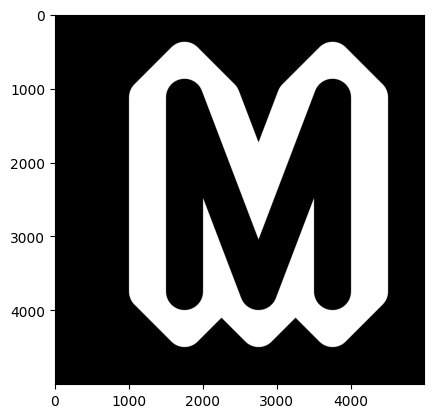

il y a 500 niveaux


In [4]:
contours_in, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
outs = []
image_dilate = image.copy()
for _ in range(thickness):
    image_dilate = cv2.dilate(image_dilate, kernel)
    image_dilate[image != 0] = 0  # dilate seulement vers l'exterieur
    contours_out, _ = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours_out) != len(contours_in):
        break
    outs.append(contours_out)
plt.imshow(image_dilate, cmap="gray")
plt.show()
print(f"il y a {len(outs)} niveaux")

In [5]:
def plot_cpl(cpl):
    cpl_color = np.zeros((*cpl.shape, 3), dtype=np.float32)
    cpl_color[:, :, 0] = np.real(cpl)
    cpl_color[:, :, 0] -= np.nanmin(cpl_color[:, :, 0])
    cpl_color[:, :, 0] /= np.nanmax(cpl_color[:, :, 0])
    cpl_color[:, :, 1] = np.imag(cpl)
    cpl_color[:, :, 1] -= np.nanmin(cpl_color[:, :, 1])
    cpl_color[:, :, 1] /= np.nanmax(cpl_color[:, :, 1])
    plt.imshow(cpl_color, vmin=0, vmax=1)
    plt.show()

In [6]:
# fill with the mandelbrot disc of center -1, radius 1/4
cpl = np.full(image.shape, np.nan, dtype=np.complex128)

def compute_inout(theta, inout:float):
    """0 for in, 1 for out"""
    minval = (1-inout)*-1.25 + inout*-1.5
    maxval = -0.75
    middle = (minval + maxval) / 2
    radius = (maxval - minval) / 2
    return radius * np.exp(1j*theta) + middle
    
for contour_in, *contours_out in zip(contours_in, *outs, strict=True):
    for cont, inout in zip((contour_in, *contours_out), np.linspace(0, 1, 1 + len(outs))):
        cont = cont[::2, ...]  # skip some points pour lisser la courbe
        theta = np.linspace(0, 2*np.pi, cont.shape[0])
        cpl[cont[:, 0, 1], cont[:, 0, 0]] = compute_inout(theta, inout)

# plot_cpl(cpl)

100%|███████████████████████████████████████| 4990/4990 [15:47<00:00,  5.27it/s]


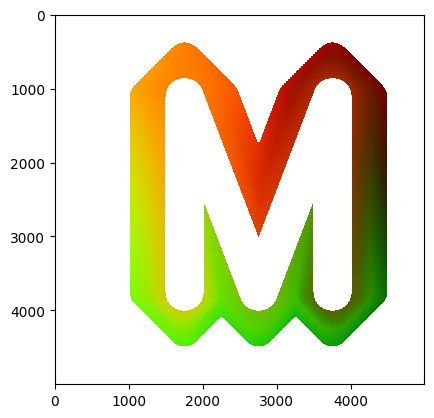

In [7]:
# interpol nan values
cpl_new = cpl.copy()

radius = 5
r = np.linspace(-1, 1, 2*radius+3, endpoint=True, dtype=np.float64)
ri, rj = np.meshgrid(r, r, indexing="ij")
disk_weights = np.maximum(0, 1 - np.sqrt(ri**2 + rj**2))
disk_weights = disk_weights[1:-1, 1:-1]
for i in tqdm.tqdm(range(radius, cpl.shape[0]-radius)):
    for j in range(radius, cpl.shape[1]-radius):
        patch = cpl[i-radius:i+radius+1, j-radius:j+radius+1]
        idx_i, idx_j = np.nonzero(~np.isnan(patch))
        if len(idx_i) == 0:
            continue
        weights = disk_weights[idx_i, idx_j]
        if (mass := weights.sum()) < 1e-8:
            continue
        weights /= mass  # to avoid division by 0
        avg = (patch[idx_i, idx_j] * weights).sum()
        cpl_new[i, j] = avg
cpl = cpl_new.copy()
plot_cpl(cpl)

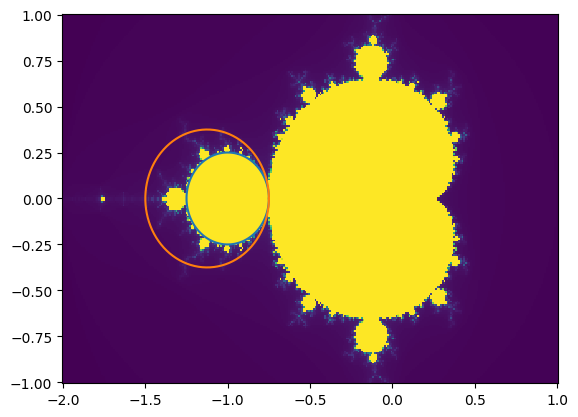

In [8]:
# display the path on the native fractal
x = np.linspace(-2, 1, 300)
y = np.linspace(-1, 1, 200)
x, y = np.meshgrid(x, y, indexing="xy")
plt.pcolor(x, y, mandelbrot(x + 1j*y))
theta = np.linspace(0, 2*np.pi, 100)
cin = compute_inout(theta, 0)
cout = compute_inout(theta, 1)
plt.plot(cin.real, cin.imag)
plt.plot(cout.real, cout.imag)
plt.show()

## fractal creation

In [9]:
fractal = np.zeros(cpl.shape, dtype=np.float32)
fractal[image != 0] = 1.0
fractal = mandelbrot(cpl, 512, out=fractal)

In [10]:
fractal_image = np.nan_to_num(fractal)
np.save("fractal.npy", fractal_image)
cmap = plt.get_cmap("plasma")
# cmap = plt.get_cmap("seismic")
fractal_image = cmap(fractal_image)
fractal_image = fractal_image[:, :, :3]
cv2.imwrite("fractal.tiff", (fractal_image * ((1 << 16) - 1)).astype(np.uint16)[:, :, ::-1])
# plt.imshow(fractal_image)
# plt.show()

True